In [7]:
import gensim
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os

# --- Configuration ---
periods = [
    {
        "name": "Before 2016",
        "rep": "../../models/chunk_3/republican_before_2016.model",
        "dem": "../../models/chunk_3/democrats_before_2016.model"
    },
    {
        "name": "2017-2020",
        "rep": "../../models/chunk_3/republican_2017_2020.model",
        "dem": "../../models/chunk_3/democrats_2017_2020.model"
    },
    {
        "name": "2021-2024",
        "rep": "../../models/chunk_3/republican_2021_2024.model",
        "dem": "../../models/chunk_3/democrats_2021_2024.model"
    }
]

# Ideological Seeds to define the axis (Right - Left)
# We use generic terms to be safe across time periods
axis_seeds = [
    ("conservative", "liberal"),
    ("republican", "democrat")
]

# --- Helper Functions ---
def expand_seeds(model, seeds, topn=5):
    """
    Expands the seed pairs by adding the top-n nearest neighbors 
    for each word in the pair.
    """
    expanded_seeds = list(seeds)
    for r_word, l_word in seeds:
        if r_word in model.wv and l_word in model.wv:
            # Get nearest neighbors
            r_neighbors = [w for w, _ in model.wv.most_similar(r_word, topn=topn)]
            l_neighbors = [w for w, _ in model.wv.most_similar(l_word, topn=topn)]
            
            # Add new pairs
            for r, l in zip(r_neighbors, l_neighbors):
                expanded_seeds.append((r, l))
                
    return list(set(expanded_seeds))

def get_processed_vectors(model, words, center=True):
    vecs = np.array([model.wv[word] for word in words])
    if center:
        vecs = vecs - vecs.mean(axis=0)
    norm = np.linalg.norm(vecs, axis=1, keepdims=True)
    norm[norm == 0] = 1 
    return vecs / norm

def align_models(model_base, model_target):
    """
    Aligns model_target (Dem) to model_base (Rep) using Iterative Procrustes.
    Returns the aligned target model.
    """
    # 1. Identify Common Vocabulary
    # Filter to top 60% by frequency in each model
    rep_vocab_sorted = sorted(model_base.wv.index_to_key, key=lambda w: model_base.wv.get_vecattr(w, "count"), reverse=True)
    dem_vocab_sorted = sorted(model_target.wv.index_to_key, key=lambda w: model_target.wv.get_vecattr(w, "count"), reverse=True)
    
    num_rep = int(0.6 * len(rep_vocab_sorted))
    num_dem = int(0.6 * len(dem_vocab_sorted))
    
    top_rep = set(rep_vocab_sorted[:num_rep])
    top_dem = set(dem_vocab_sorted[:num_dem])
    
    common_vocab = list(top_rep.intersection(top_dem))
    
    # Sort by total frequency to find robust anchors
    common_vocab.sort(key=lambda w: model_base.wv.get_vecattr(w, "count") + model_target.wv.get_vecattr(w, "count"), reverse=True)
    
    # 2. Rough Alignment (Top 3000)
    initial_anchors = common_vocab[:3000]
    vecs_base_rough = get_processed_vectors(model_base, initial_anchors, center=True)
    vecs_target_rough = get_processed_vectors(model_target, initial_anchors, center=True)
    
    # Rotation 1
    m = vecs_target_rough.T @ vecs_base_rough
    u, _, vt = np.linalg.svd(m)
    rotation_1 = u @ vt
    vecs_target_rotated = vecs_target_rough @ rotation_1
    
    # 3. Filter Anchors (Remove words that didn't align well)
    similarities = np.sum(vecs_base_rough * vecs_target_rotated, axis=1)
    distances = 1 - similarities
    anchor_scores = sorted(zip(initial_anchors, distances), key=lambda x: x[1])
    
    # Keep best 1500
    refined_anchors = [w for w, d in anchor_scores[:1500]]
    
    # 4. Final Alignment (Rotation + Translation)
    vecs_base_final = get_processed_vectors(model_base, refined_anchors, center=True)
    vecs_target_final = get_processed_vectors(model_target, refined_anchors, center=True)
    
    m_final = vecs_target_final.T @ vecs_base_final
    u_final, _, vt_final = np.linalg.svd(m_final)
    rotation_final = u_final @ vt_final
    
    # Apply Rotation to Target Model
    model_target.wv.vectors = model_target.wv.vectors @ rotation_final
    
    # Apply Translation (Center Matching)
    mean_base = np.mean(model_base.wv[refined_anchors], axis=0)
    mean_target = np.mean(model_target.wv[refined_anchors], axis=0) # Now rotated
    model_target.wv.vectors = model_target.wv.vectors + (mean_base - mean_target)
    
    # Clear Cache
    if hasattr(model_target.wv, 'fill_norms'):
        model_target.wv.fill_norms(force=True)
        
    return model_target, common_vocab

def construct_semantic_axis(model, seeds):
    """
    Constructs an axis vector (e.g., Conservative -> Liberal).
    We use the BASE model (Rep) to define the 'standard' direction of this axis.
    Axis = Mean(Vector(Right) - Vector(Left))
    """
    axis_vectors = []
    for right, left in seeds:
        if right in model.wv and left in model.wv:
            v_r = model.wv[right]
            v_l = model.wv[left]
            v_r = v_r / np.linalg.norm(v_r)
            v_l = v_l / np.linalg.norm(v_l)
            axis_vectors.append(v_r - v_l)
            
    if not axis_vectors:
        return None
    
    # Average and Normalize
    final_axis = np.mean(axis_vectors, axis=0)
    final_axis = final_axis / np.linalg.norm(final_axis)
    return final_axis

# --- Main Execution ---

for period in periods:
    print(f"\n=== Processing Period: {period['name']} ===")
    
    # 1. Load Models
    print(f"Loading {period['rep']}...")
    model_rep = gensim.models.Word2Vec.load(period['rep'])
    model_dem = gensim.models.Word2Vec.load(period['dem'])
    
    # 2. Align Models (Dem -> Rep)
    print("Aligning models...")
    model_dem, common_vocab = align_models(model_rep, model_dem)
    
    # 3. Construct the "Conservative-Liberal" Axis
    # We define the axis using the Republican model's geometry as the 'baseline'
    current_seeds = expand_seeds(model_rep, axis_seeds, topn=5)
    axis_vector = construct_semantic_axis(model_rep, current_seeds)
    if axis_vector is None:
        print("Error: Seeds not found in vocabulary.")
        continue
        
    # 4. Analyze "Core Vocabulary" 
    # This avoids the "Rare Word Trap"
    num_anchors = int(0.8 * len(common_vocab))
    core_vocab = common_vocab[:num_anchors]
    
    results = []
    for word in core_vocab:
        # # Skip short words/noise
        # if len(word) < 3: 
        #     continue
            
        v_rep = model_rep.wv[word]
        v_dem = model_dem.wv[word]
        
        # Normalize
        v_rep = v_rep / np.linalg.norm(v_rep)
        v_dem = v_dem / np.linalg.norm(v_dem)
        
        # Project onto Axis (Dot Product)
        # Positive Score = More Conservative/Republican
        # Negative Score = More Liberal/Democrat
        proj_rep = np.dot(v_rep, axis_vector)
        proj_dem = np.dot(v_dem, axis_vector)
        
        # Measure Polarization (Absolute Difference in Projection)
        polarization = abs(proj_rep - proj_dem)
        
        results.append({
            "word": word,
            "rep_score": proj_rep,
            "dem_score": proj_dem,
            "polarization": polarization
        })
        
    # 5. Display Top Polarized Words
    df = pd.DataFrame(results)
    df = df.sort_values("polarization", ascending=False)
    top_polarized = df.head(15)
    
    print(f"\n--- Top 15 Polarized Words on 'Conservative-Liberal' Axis ({period['name']}) ---")
    print(f"{'Word':<15} {'Polarization':<12} {'Rep Score':<10} {'Dem Score':<10}")
    print("-" * 50)
    for _, row in top_polarized.iterrows():
        # Interpretation: 
        # If Rep Score is 0.5 and Dem Score is -0.2, Reps see it as 'Conservative', Dems see it as 'Liberal'
        print(f"{row['word']:<15} {row['polarization']:<12.3f} {row['rep_score']:<10.3f} {row['dem_score']:<10.3f}")
        
    # Optional: Save to CSV
    os.makedirs("../../output/axis", exist_ok=True)
    df.to_csv(f"../../output/axis/{period['name']}.csv", index=False)


=== Processing Period: Before 2016 ===
Loading ../../models/chunk_3/republican_before_2016.model...
Aligning models...

--- Top 15 Polarized Words on 'Conservative-Liberal' Axis (Before 2016) ---
Word            Polarization Rep Score  Dem Score 
--------------------------------------------------
huckabee        0.540        0.456      -0.084    
rand            0.516        0.523      0.007     
leftist         0.509        -0.415     0.094     
ron             0.497        0.500      0.004     
progressive     0.459        -0.140     0.319     
jindal          0.427        0.375      -0.052    
walker          0.425        0.451      0.025     
kaine           0.421        -0.011     0.410     
liberal         0.420        -0.279     0.141     
fiscal_conservative 0.419        0.480      0.060     
rick_santorum   0.418        0.320      -0.098    
marco_rubio     0.412        0.451      0.039     
dean            0.411        -0.140     0.270     
social_justice  0.399        -0.36

Loading data for visualization...


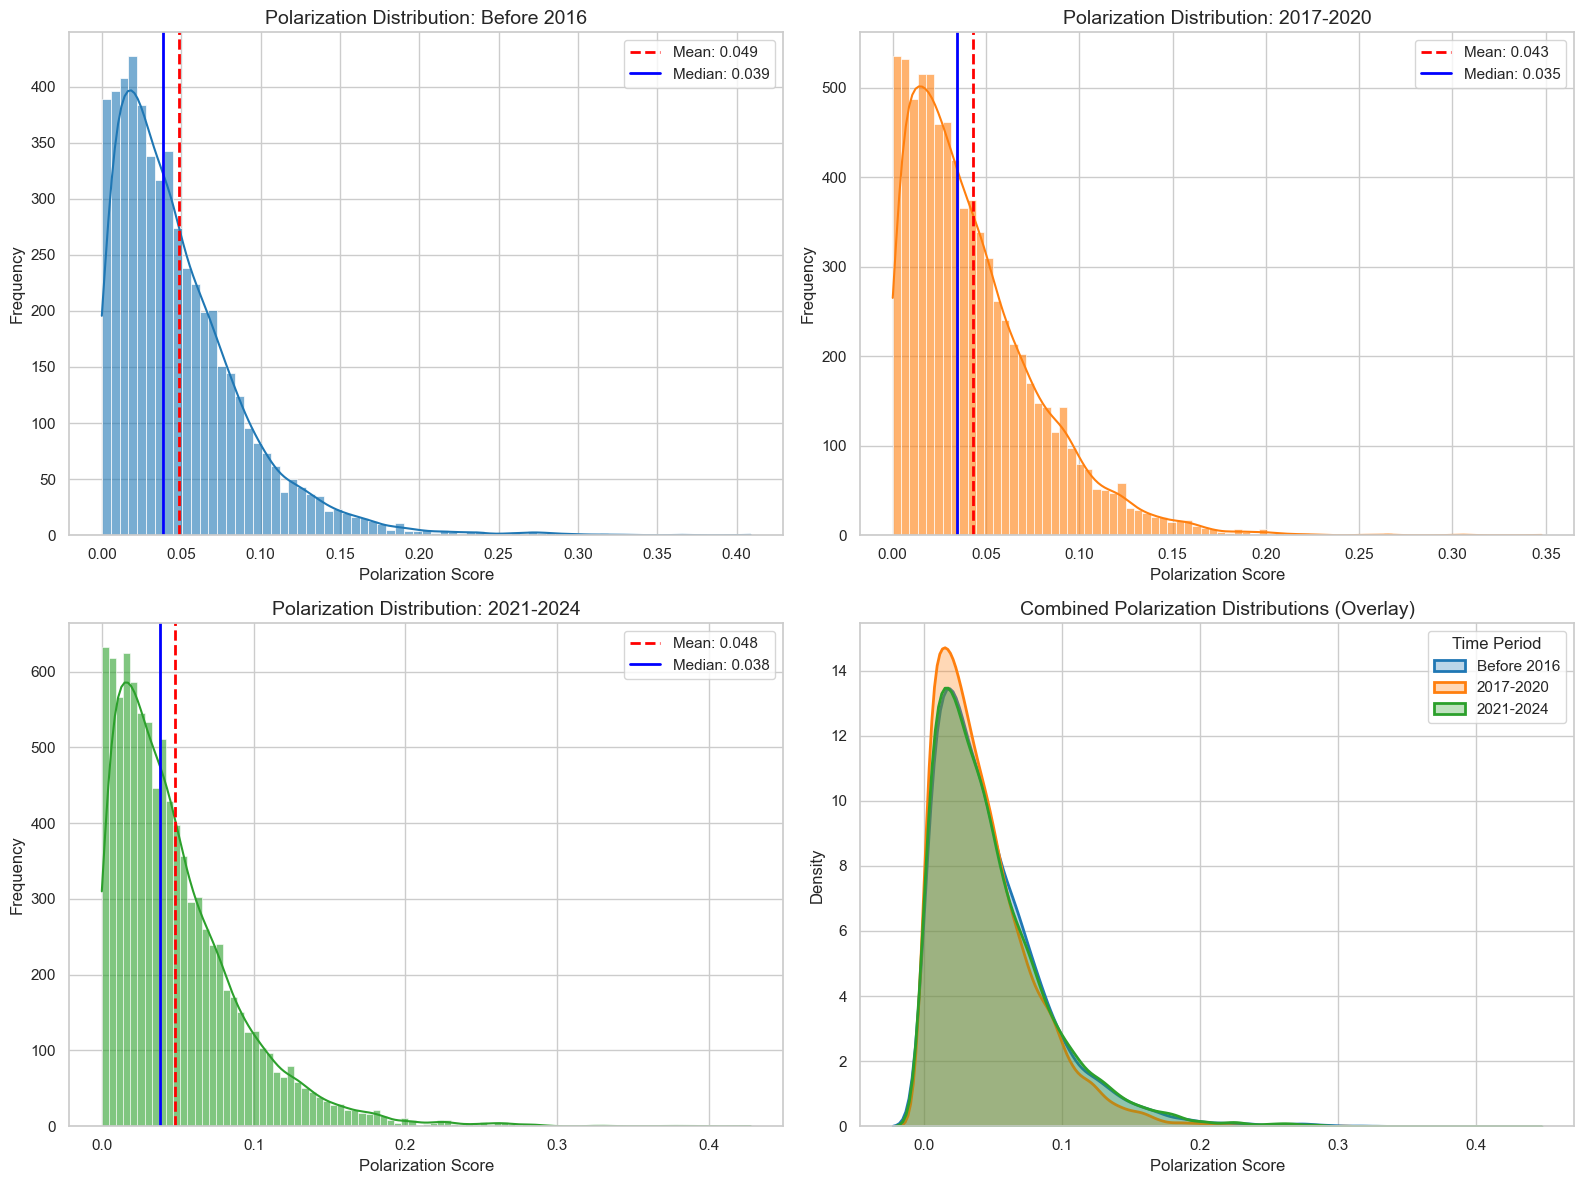

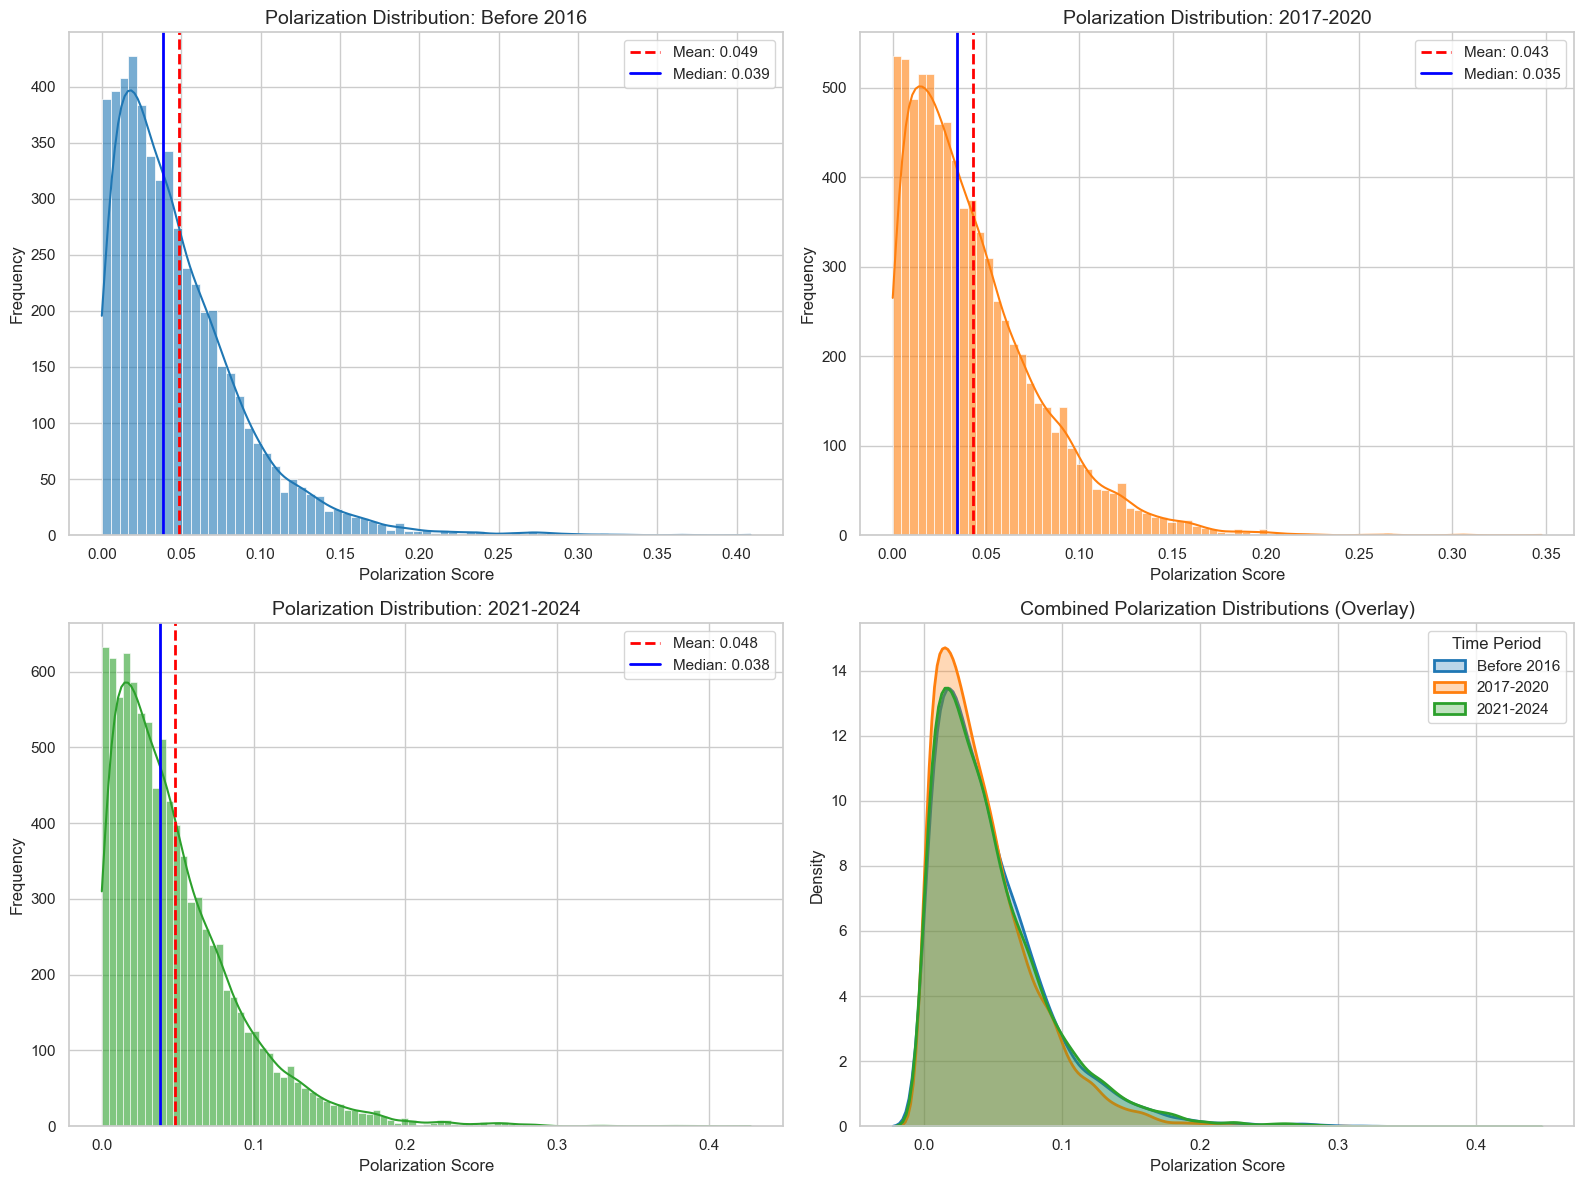

In [6]:
# ...existing code...

# --- Visualization of Polarization Distributions ---
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
period_names = ["Before 2016", "2017-2020", "2021-2024"]
base_path = "../../output/axis"

# Prepare data storage
data_frames = {}

# Load data
print("Loading data for visualization...")
for name in period_names:
    file_path = os.path.join(base_path, f"{name}.csv")
    if os.path.exists(file_path):
        data_frames[name] = pd.read_csv(file_path)
    else:
        print(f"Warning: File not found for {name} at {file_path}")

# ...existing code...
# Check if we have data to plot
if data_frames:
    # Set up the figure with 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten() # Flatten to 1D array for easy indexing
    
    sns.set_theme(style="whitegrid")

    # Plot 1-3: Individual Distributions
    for i, name in enumerate(period_names):
        if name in data_frames:
            df = data_frames[name]
            sns.histplot(
                data=df, 
                x="polarization", 
                kde=True, 
                ax=axes[i],
                color=sns.color_palette("tab10")[i],
                edgecolor=None,
                alpha=0.6
            )
            
            # Calculate Mean and Median
            mean_val = df["polarization"].mean()
            median_val = df["polarization"].median()
            
            # Add vertical lines
            axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
            axes[i].axvline(median_val, color='blue', linestyle='-', linewidth=2, label=f'Median: {median_val:.3f}')
            
            axes[i].set_title(f"Polarization Distribution: {name}", fontsize=14)
            axes[i].set_xlabel("Polarization Score")
            axes[i].set_ylabel("Frequency")
            axes[i].legend()

    # Plot 4: Combined Distribution (Overlay)
    ax_combined = axes[3]
    for i, name in enumerate(period_names):
        if name in data_frames:
            sns.kdeplot(
                data=data_frames[name], 
                x="polarization", 
                ax=ax_combined, 
                label=name, 
                fill=True, 
                alpha=0.3,
                linewidth=2,
                color=sns.color_palette("tab10")[i]
            )
    
    ax_combined.set_title("Combined Polarization Distributions (Overlay)", fontsize=14)
    ax_combined.set_xlabel("Polarization Score")
    ax_combined.set_ylabel("Density")
    ax_combined.legend(title="Time Period")

    plt.tight_layout()# filepath: c:\Users\cyyua\DS\word_embedding\notebooks\analysis\axis_analysis.ipynb
# ...existing code...
# Check if we have data to plot
if data_frames:
    # Set up the figure with 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten() # Flatten to 1D array for easy indexing
    
    sns.set_theme(style="whitegrid")

    # Plot 1-3: Individual Distributions
    for i, name in enumerate(period_names):
        if name in data_frames:
            df = data_frames[name]
            sns.histplot(
                data=df, 
                x="polarization", 
                kde=True, 
                ax=axes[i],
                color=sns.color_palette("tab10")[i],
                edgecolor=None,
                alpha=0.6
            )
            
            # Calculate Mean and Median
            mean_val = df["polarization"].mean()
            median_val = df["polarization"].median()
            
            # Add vertical lines
            axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
            axes[i].axvline(median_val, color='blue', linestyle='-', linewidth=2, label=f'Median: {median_val:.3f}')
            
            axes[i].set_title(f"Polarization Distribution: {name}", fontsize=14)
            axes[i].set_xlabel("Polarization Score")
            axes[i].set_ylabel("Frequency")
            axes[i].legend()

    # Plot 4: Combined Distribution (Overlay)
    ax_combined = axes[3]
    for i, name in enumerate(period_names):
        if name in data_frames:
            sns.kdeplot(
                data=data_frames[name], 
                x="polarization", 
                ax=ax_combined, 
                label=name, 
                fill=True, 
                alpha=0.3,
                linewidth=2,
                color=sns.color_palette("tab10")[i]
            )
    
    ax_combined.set_title("Combined Polarization Distributions (Overlay)", fontsize=14)
    ax_combined.set_xlabel("Polarization Score")
    ax_combined.set_ylabel("Density")
    ax_combined.legend(title="Time Period")

    plt.tight_layout()